In [1]:
%run ../Setup.ipynb

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import datetime  
import numpy as np
from matplotlib import dates
from datetime import timedelta
from sklearn import preprocessing
import plotly.offline as py
import plotly.graph_objs as go
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, Output

from isac.plotting import plot_helper as isac_plotter
from isac.database.connection import database_connector as connector
from isac import configuration
from data_compare import sensor_data_provider as sdp        

# Hintergrund
Aufbauend auf der Analyse zum Stromverbrauch eines Förderbandes bzw. dem Leistungsverbrauches des gesamten Systems konnten wir feststellen, dass es in unregelmäßigen Abständen zu Staus von Werkstückträgern an unterschiedlichen Sensoren kommt. Ebenso konnten wir Signale an den Sensoren feststellen, die als "False Negative" oder "False Positive" einzuordnen waren.

# Idee
Um sicherzustellen, dass es nicht an einzelnen Sensoren oder einem bestimmten Werkstückträger liegt, haben wir analysiert, wie sich bestimmte Werkstückträger in Kombination mit den Sensoren verhalten. Dazu wurde ein interaktives Diagramm (Plotly + ipywidgets) erstellt, mit dem diese Daten dargestellt werden sollten. 

# Einzelne WST anzeigen
Zu den einzelnen passierenden WST wurde berechnet, wann dieser einen Sensor passiert und wieder verlässt. Innerhalb eines Zyklus, basierend auf der Anzahl der im System verfügbaren Werkstückträger, kann dann dieser Werkstückträger eindeutig identifiziert und so einzelne Werkstückträger herausgefiltert werden. Das wird benötigt, um mögliche Staus erkennen zu können oder ob es Fehler an den einzelnen Werkstückträgern gibt.

In [2]:
py.init_notebook_mode(connected = True)

dataProvider = sdp.SensorDataProvider()
connection = connector.DatabaseConnector(name = configuration.project_database).connect()
available_sensors = sorted(connection.getCollectionNames())
sensor_data = {}

relevant_sensors = ["Bandbero_99_B01_Meldungen", "Bandbero_99_B11_Meldungen", "Bandbero_99_B13_Meldungen", "Pneumatikzylinder_1_K1_Befehle", "Pneumatikzylinder_1_K2_Befehle", "Pneumatikzylinder_2_K1_Befehle", "Pneumatikzylinder_2_K2_Befehle", "Pneumatikzylinder_3_K1_Befehle", "Pneumatikzylinder_3_K2_Befehle", "Pneumatikzylinder_4_K1_Befehle", "Pneumatikzylinder_4_K2_Befehle", "Pneumatikzylinder_99_K1_Befehle", "Pneumatikzylinder_99_K2_Befehle", "Pneumatikzylinder_99_K3_Befehle", "Pneumatikzylinder_99_K4_Befehle", "Pneumatikzylinder_5_K1_Befehle", "Pneumatikzylinder_5_K2_Befehle", "Bandbero_99_B02_Meldungen", "Bandbero_1_B01_Meldungen", "Bandbero_1_B02_Meldungen", "Bandbero_1_B03_Meldungen", "Bandbero_2_B01_Meldungen", "Bandbero_2_B02_Meldungen", "Bandbero_2_B03_Meldungen", "Bandbero_3_B01_Meldungen", "Bandbero_3_B02_Meldungen", "Bandbero_3_B03_Meldungen", "Bandbero_4_B01_Meldungen", "Bandbero_4_B02_Meldungen", "Bandbero_99_B06_Meldungen", "Bandbero_99_B07_Meldungen", "Bandbero_99_B08_Meldungen", "Bandbero_99_B09_Meldungen", "Bandbero_99_B10_Meldungen", "Bandbero_99_B12_Meldungen", "Bandbero_99_B14_Meldungen", "Bandbero_5_B01_Meldungen", "Bandbero_5_B02_Meldungen", "Bandbero_99_B15_Meldungen", "PÜberwachung_ZS_B104_Leistungen", "PÜberwachung_ZS_B103_Leistungen", "Simocode_Q11M1_Leistungen", "EnergyMeter_ZS_K31_Leistungen", "PAC3200_ZS_P0_Leistungen", "Sinamicsachse_US3_M1_Leistungen", "Sinamicsachse_US3_M2_Leistungen", "Sinamicsachse_US3_M3_Leistungen", "Sinamicsachse_US3_M4_Leistungen"]
for sensor_name in available_sensors:
    if sensor_name not in relevant_sensors:
        continue
        
    sensor_data[sensor_name] = dataProvider.getSensorData(sensor_name)
    sensor_data[sensor_name]['Zeit'] = pd.to_datetime(sensor_data[sensor_name]['Zeit'], unit='ms')

### Fehlerhafte Signale korrigieren

In [3]:
def plotErrors(dataframe):
    for i in range(0, len(dataframe)):
        current_value = abs(dataframe.loc[i, 'Wert'])
        if (current_value == 0):
            current_value = -1

        if (i == 0):
            value_before = 1
            dataframe.loc[i, 'recognize_error'] = value_before + current_value
        else:
            value_before = dataframe.loc[i - 1, 'recognize_error']
            dataframe.loc[i, 'recognize_error'] = value_before + current_value
            
    fig, axes = plt.subplots(figsize=(20,5))
    hfmt = dates.DateFormatter('%H:%M')
    axes.xaxis.set_major_formatter(hfmt)
    dataframe.plot(drawstyle="steps-post", label='Gelieferte Signale des Sensors', color='purple', ax=axes, x='Zeit',  y='recognize_error', linewidth=1.0);
    axes.legend(loc='upper left')
    
def fixErrors(dataframe, value_positive):
    for i in range(0, len(dataframe)):
        # Vorheriger Wert
        if (i == 0):
            pass
        else:
            value_before = dataframe.loc[i - 1, 'Wert']
            value_current = dataframe.loc[i, 'Wert']
            
            if (value_before == value_current):
                if (value_current == 0):
                    dataframe.loc[i, 'Wert'] = value_positive
                else:
                    dataframe.loc[i, 'Wert'] = 0
            
    return dataframe

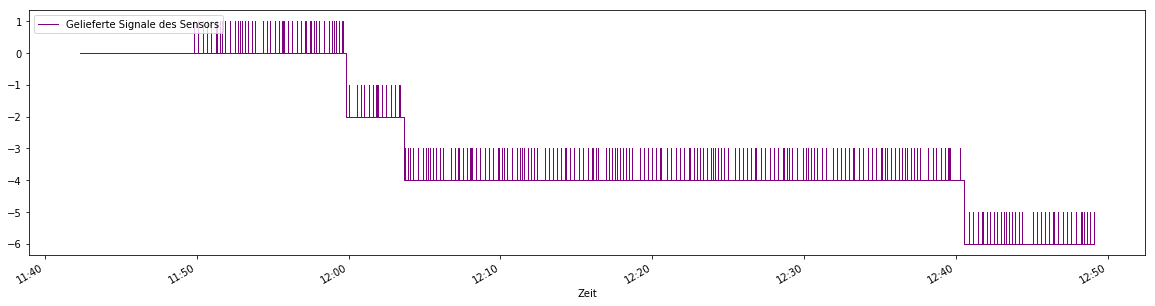

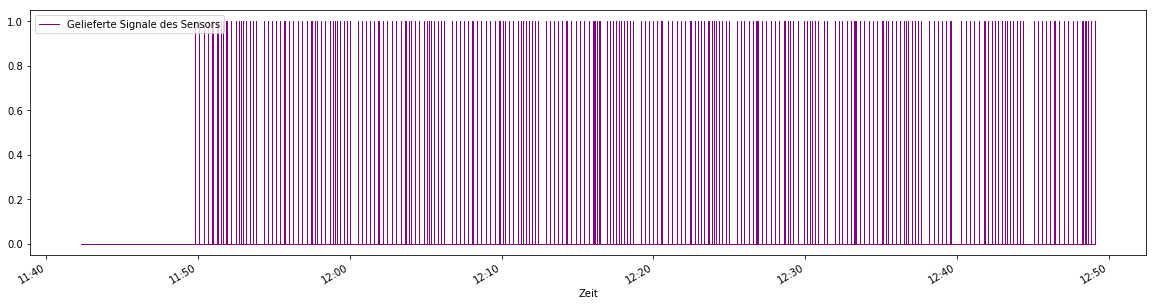

In [4]:
plotErrors(sensor_data["Bandbero_99_B06_Meldungen"])
sensor_data["Bandbero_99_B06_Meldungen"] = fixErrors(sensor_data["Bandbero_99_B06_Meldungen"], 1)
plotErrors(sensor_data["Bandbero_99_B06_Meldungen"])

#### Alle Signale korrigieren

In [5]:
for sensor_name in sensor_data:
    sensor_data[sensor_name] = fixErrors(sensor_data[sensor_name], 1)

#### Entfernen des Initialisierungssignals (Danach passiert 7 Minuten lang nichts)

In [6]:
for sensor_name in sensor_data:
    sensor_data[sensor_name] = sensor_data[sensor_name][1:]

# Plotly

In [7]:
selectable_sensors = []
selectable_sensors.append(None)
selectable_sensors.extend([s for s in available_sensors])

fig = None

sensor_widget_1 = widgets.Dropdown(
    options=selectable_sensors,
    description='Sensor 1',
    value="Bandbero_99_B15_Meldungen"
)

sensor_widget_2 = widgets.Dropdown(
    options=selectable_sensors,
    description='Sensor 2',
    value=None
)

sensor_widget_3 = widgets.Dropdown(
    options=selectable_sensors,
    description='Sensor 3',
    value=None#"Bandbero_99_B08_Meldungen"
)

show_wst_1 = widgets.Checkbox(
    description='Werkstückträger 1',
    value=True,
)

show_wst_2 = widgets.Checkbox(
    description='Werkstückträger 2',
    value=True,
)

show_wst_3 = widgets.Checkbox(
    description='Werkstückträger 3',
    value=True,
)

show_wst_4 = widgets.Checkbox(
    description='Werkstückträger 4',
    value=True,
)

show_wst_5 = widgets.Checkbox(
    description='Werkstückträger 5',
    value=True,
)

show_wst_6 = widgets.Checkbox(
    description='Werkstückträger 6',
    value=True,
)


# Daten des Sensors Filtern
def filter_data(sensor, selected_wst):  
    if sensor is None:
        return None
    
    data = sensor_data[sensor]
        
    cycle_every_n = 12 # Ein Zyklus ist nach n Signalen komplett
    
    # selected wst -1, da selected_wst von 1-6 statt 0-5
    wst_data = pd.concat([data[0 + (selected_wst-1) * 2::cycle_every_n],
                          data[1 + (selected_wst-1) * 2::cycle_every_n]]).sort_values(by=['Zeit'])

    return wst_data

# Sensordaten zur Visualisierung vorbereiten
def get_sensor_data_trace(data, name, color, dash, legendgroup):
    
    trace = go.Scatter(
        x = data["Zeit"],
        y = data["Wert"],
        # legendgroup = legendgroup,
        line = dict(
            shape='hv',
            color=color,
            dash=dash
        ),
        name = name
    )
        
    return trace

# Plot zeichnen
def plot_sensor_data(sensor_1, sensor_2, sensor_3, show_wst_1, show_wst_2, show_wst_3, show_wst_4, show_wst_5, show_wst_6):
    global fig
    
    # Farben der einzelnen Werkstückträger
    wst_colors = {
        1 : "#FF4500", # Orange-Red
        2 : "#FFAE42", # Yellow-Orange
        3 : "#9ACD32", # Yellow-Green
        4 : "#0099CC", # Blue-Green
        5 : "#8A2BE2", # Blue-Violet
        6 : "#D02090", # Blue-Green
    }
    
    # Linienart der Sensoren
    sensor_dash = {
        1 : "solid",
        2 : "dot",
        3 : "longdash"
    }
    
    # Welche Werkstückträger angezeigt werden sollen
    show_wst = {
        1 : show_wst_1,
        2 : show_wst_2,
        3 : show_wst_3,
        4 : show_wst_4,
        5 : show_wst_5,
        6 : show_wst_6,
    }
    
    # Daten für den Chart vorbereiten
    data = []
    for i in range(1, 7):
        if show_wst[i] is False:
            continue
            
        if sensor_1 is not None:
            data.append(
                get_sensor_data_trace(
                    filter_data(sensor_1, i),
                    sensor_1 + "_WST_" + str(i),
                    wst_colors[i],
                    sensor_dash[1],
                    "WST_" + str(i)
                ))
        if sensor_2 is not None:
            data.append(
                get_sensor_data_trace(
                    filter_data(sensor_2, i),
                    sensor_2 + "_WST_" + str(i),
                    wst_colors[i],
                    sensor_dash[2],
                    "WST_" + str(i)
                ))
        if sensor_3 is not None:
            data.append(
                get_sensor_data_trace(
                    filter_data(sensor_3, i),
                    sensor_3 + "_WST_" + str(i),
                    wst_colors[i],
                    sensor_dash[3],
                    "WST_" + str(i)
                ))

    # Layout anpassen
    layout = go.Layout(
        title=go.layout.Title(
            text="Sensor Data",
        ),
        legend=dict(orientation="v"),
        yaxis={'zeroline': False},

        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(step='all',
                         label="All"
                        ),
                    dict(count=1,
                         label='1m',
                         step='minute',
                         stepmode='todate',
                        ),
                    dict(count=5,
                         label='5m',
                         step='minute',
                         stepmode='todate',
                        ),
                    dict(count=15,
                         label='15m',
                         step='minute',
                         stepmode='todate'
                        ),
                ]),
            ),
            rangeslider=dict(
                visible=True,
            ),
            type='date'
        )
    )
    
    # Chart erstellen
    fig = go.Figure(data=data, layout=layout)
    
    # Chart anzeigen
    py.iplot(fig)

interact(plot_sensor_data,
         sensor_1 = sensor_widget_1,
         sensor_2 = sensor_widget_2,
         sensor_3 = sensor_widget_3,
         show_wst_1 = show_wst_1,
         show_wst_2 = show_wst_2,
         show_wst_3 = show_wst_3,
         show_wst_4 = show_wst_4,
         show_wst_5 = show_wst_5,
         show_wst_6 = show_wst_6,
        )

<function __main__.plot_sensor_data>

In [8]:
# Speichert den Plot offline mit den eingestellten Standardoptionen als .html
# Es ist leider nicht möglich die Elemente außerhalb des Plots mitzuexportieren (Sensor, WST etc.)
py.plot(fig, filename="temporary-generated-files/wst_jam_analysis_demo.html", auto_open=True)

'file:///home/isac/projects/transport-module-power-analysis/notebooks/sensor_analysis/temporary-generated-files/wst_jam_analysis_demo.html'

# Analyse der Sensoren und Werkstückträger

Die Sensoren werden aktiv, wenn sich ein Werkstückträger am Sensor befindet. Mit den Datensätzen kann man so herausfinden, wielange jeder Sensor aktiv ist, wie sehr dieser ausgelastet ist und wie sich die jeweiligen Werkstückträger bei den einzelnen Sensoren verhalten.

Wir haben die Werkstückträger bei den einzelnen Sensoren miteinander verglichen, um herauszufinden, ob einzelne Werkstückträger zu Staus an bestimmten Sensoren führen. Potentielle Werkstückträger konnten wir finden, indem wir nach Werkstückträgern gesucht haben, deren Verarbeitungsdauer länger als Faktor X des Medians aller Werkstückträger an diesem Sensor ist.

So konnten wir bei einem Faktor 1.5 feststellen, dass die Sensoren

- 1) Bandbero_5_B02_Meldungen	
- 2) Bandbero_99_B11_Meldungen	
- 3) Bandbero_99_B10_Meldungen	
- 4) Bandbero_99_B15_Meldungen	
- 5) Pneumatikzylinder_99_K3_Befehle

Auffälligkeiten zeigten. 3) konnten wir bei der visuellen Nachkontrolle wieder ausschließen, da der Sensor am Anfang falsche Daten gesendet zu haben scheint. Die anderen 4 scheinen einen Zusammenhang zu haben, wobei diese 4 alle auf 2) zurückzuführen sind. Bei 2) gibt es einen Werkstückträger, der bei jedem Zyklus eine immer längere Verarbeitungszeit benötigt.

![title](generated-static-images/bandbero_99_b11_meldungen_wst_6.png)

In [9]:
df_sensor_info = pd.DataFrame(columns=["sensor",
                                       "sum_time",
                                       "active",
                                       "inactive", 
                                       "active_1",
                                       "active_2",
                                       "active_3",
                                       "active_4",
                                       "active_5",
                                       "active_6",
                                       "wst_median",
                                       "wst_max",
                                       "wst_max_median_factor"
                                      ])

for sensor in sensor_data:
    sensor_data[sensor]["Active"] = sensor_data[sensor]["Zeit"].diff()
    sensor_sum_time = sensor_data[sensor]["Active"].sum()
    sensor_active = sensor_data[sensor]["Active"][sensor_data[sensor]["Wert"] == 0].sum()
    sensor_inactive = sensor_data[sensor]["Active"][sensor_data[sensor]["Wert"] == 1].sum()
    
    # Filtern ungültiger Sensoren
    if (len(sensor_data[sensor]["Wert"].unique()) != 2):
        # Zuviele Werte, kann kein true/false Sensor sein
        continue
    if (0 not in sensor_data[sensor]["Wert"].unique() or
        1 not in sensor_data[sensor]["Wert"].unique()):
        # Prüfe ob 0/1 Sensor
        continue
    if (sensor_sum_time <= timedelta(minutes=50)):
        # Filtern von Sensoren die zu kurz Daten sammeln
        continue
        
    wst_active_times = {}
        
    for wst in range(1, 7):
        wst_active = "active_" + str(wst)
        wst_series = filter_data(sensor, wst)
        wst_series[wst_active] = wst_series["Zeit"].diff()
        sensor_active_wst_time = wst_series[wst_active][wst_series["Wert"] == 0].sum()
        wst_active_times[wst_active] = sensor_active_wst_time
    
    wst_median = np.median(list(wst_active_times.values()))
    wst_max = np.max(list(wst_active_times.values()))
    wst_factor = wst_max / wst_median

    df_sensor_info.loc[len(df_sensor_info)] = [sensor,
                                               sensor_sum_time,
                                               sensor_active,
                                               sensor_inactive, 
                                               wst_active_times["active_1"],
                                               wst_active_times["active_2"],
                                               wst_active_times["active_3"],
                                               wst_active_times["active_4"],
                                               wst_active_times["active_5"],
                                               wst_active_times["active_6"],
                                               wst_median,
                                               wst_max,
                                               wst_factor]
    
df_sensor_info[df_sensor_info["wst_max_median_factor"] > 1.5].sort_values(by="active", ascending = False)

,sensor,sum_time,active,inactive,active_1,active_2,active_3,active_4,active_5,active_6,wst_median,wst_max,wst_max_median_factor
12,Bandbero_5_B02_Meldungen,01:00:32.610000,00:16:32.743000,00:43:59.867000,00:01:03.764000,00:05:00.541000,00:02:12.326000,00:01:03.252000,00:05:00.467000,00:02:12.393000,00:02:12.359500,00:05:00.541000,2.270642
20,Bandbero_99_B11_Meldungen,01:00:38.673000,00:08:49.381000,00:51:49.292000,00:00:49.888000,00:00:49.751000,00:00:48.903000,00:00:49.969000,00:00:48.819000,00:04:42.051000,00:00:49.819500,00:04:42.051000,5.661458
19,Bandbero_99_B10_Meldungen,01:04:37.808000,00:06:01.889000,00:58:35.919000,00:05:07.797000,00:00:15.110000,00:00:09.853000,00:00:09.762000,00:00:09.770000,00:00:09.597000,00:00:09.811500,00:05:07.797000,31.371044
23,Bandbero_99_B15_Meldungen,01:00:37.147000,00:03:33.695000,00:57:03.452000,00:00:07.131000,00:00:32.372000,00:00:56.515000,00:01:00.273000,00:00:42.852000,00:00:14.552000,00:00:37.612000,00:01:00.273000,1.602494
36,Pneumatikzylinder_99_K3_Befehle,01:00:56.288000,00:01:05.775000,00:59:50.513000,00:00:26.369000,00:00:07.912000,00:00:07.976000,00:00:07.893000,00:00:07.902000,00:00:07.723000,00:00:07.907000,00:00:26.369000,3.334893


## Prüfen, ob es am Werkstückträger generell liegt

Nachdem wir festgestellt hatten, dass es anscheinend Probleme bei einem bestimmten Werkstückträger an einem Sensor gibt, der Staus verursachen kann, wollten wir feststellen, ob der Werkstückträger auch an anderen Sensoren Probleme verursacht.

Dies prüften wir, indem wir die durchschnittliche Verweildauer der einzelnen Werkstückträger an allen Sensoren miteinander verglichen. Wir konnten keine weiteren Auffälligkeiten finden.

In [10]:
print("median")
print(df_sensor_info[["active_1", "active_2", "active_3", "active_4", "active_5", "active_6"]].median())
print("\nmean")
print(df_sensor_info[["active_1", "active_2", "active_3", "active_4", "active_5", "active_6"]].mean())

median
active_1   00:00:07.788000
active_2   00:00:07.804000
active_3   00:00:07.641000
active_4   00:00:07.659000
active_5   00:00:07.635000
active_6   00:00:07.685000
dtype: timedelta64[ns]

mean
active_1   00:00:53.518868
active_2   00:00:53.114684
active_3   00:00:48.900263
active_4   00:00:47.029631
active_5   00:00:52.955342
active_6   00:00:48.850789
dtype: timedelta64[ns]
